# Solving Burgers' equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Numerical solution

We'll use the same finite-volume grid class, with one change&mdash;we'll allow for "outflow" boundary conditions.  These simply enforce a zero gradient in the ghost cells, so:

$$u_{\mathrm{lo}-1} = u_{\mathrm{lo}}$$
$$u_{\mathrm{lo}-2} = u_{\mathrm{lo}}$$

and similar at the right boundary.

In [21]:
class FVGrid:

    def __init__(self, nx, ng, bc="outflow",
                 xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered, left and right edges
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.u = self.scratch_array()
        self.uinit = self.scratch_array()

        self.bc = bc
        
    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self, atmp):
        """ fill all ghostcells """
 
        if self.bc == "periodic":

            # left boundary
            atmp[0:self.ilo] = atmp[self.ihi-self.ng+1:self.ihi+1]

            # right boundary
            atmp[self.ihi+1:] = atmp[self.ilo:self.ilo+self.ng]

        elif self.bc == "outflow":

            # left boundary
            atmp[0:self.ilo] = atmp[self.ilo]

            # right boundary
            atmp[self.ihi+1:] = atmp[self.ihi]

        else:
            sys.exit("invalid BC")

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))
    
    def plot(self, title=None):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.plot(self.x, self.uinit, ls=":", label="initial conditions")
        ax.plot(self.x, self.u)
        ax.legend()
        if title:
            ax.set_title(title)
        return fig

We get the interface state by reconstructing $u$ to each interface,
getting left and right states and then solve the Riemann problem. Once we have the interface state, $u_{i+1/2}$, we can compute the flux:

$$F_{i+1/2} = \frac{1}{2} u_{i+1/2}^2$$

and then the divergence of the fluxes:

$$-\frac{1}{\Delta x} (F_{i+1/2} - F_{i-1/2}) = -\frac{1}{\Delta x} \left ( \frac{1}{2} u_{i+1/2}^2 - \frac{1}{2} u_{i-1/2}^2 \right )$$

In [22]:
def flux_update(gr, u):
    """compute -div{F} for linear advection"""

    # slope -- we'll do the minmod limiter
    
    # dl = u_i - u_{i-1}
    dl = gr.scratch_array()
    dl[gr.ilo-1:gr.ihi+2] = u[gr.ilo-1:gr.ihi+2] - u[gr.ilo-2:gr.ihi+1]

    # dr = u_{i+1} - u_i
    dr = gr.scratch_array()
    dr[gr.ilo-1:gr.ihi+2] = u[gr.ilo:gr.ihi+3] - u[gr.ilo-1:gr.ihi+2]
    
    d1 = np.where(np.fabs(dl) < np.fabs(dr), dl, dr)
    du = np.where(dl*dr > 0.0, d1, 0.0)

    # unlimited
    #du[gr.ilo-1:gr.ihi+2] = 0.5*(u[gr.ilo:gr.ihi+3] - u[gr.ilo-2:gr.ihi+1])

    
    # compute the left and right interface states
    # Note that there are 1 more interfaces than zones

    ul = gr.scratch_array()
    ur = gr.scratch_array()
    
    # u_{i-1/2,R} = u_i - 1/2 du_i
    ur[gr.ilo:gr.ihi+2] = u[gr.ilo:gr.ihi+2] - 0.5 * du[gr.ilo:gr.ihi+2]

    # u_{i-1/2,L} = u_{i-1} + 1/2 du_{i-1}
    ul[gr.ilo:gr.ihi+2] = u[gr.ilo-1:gr.ihi+1] + 0.5 * du[gr.ilo-1:gr.ihi+1]
    
    # now do the Riemann problem
    
    S = 0.5 * (ul + ur)
    ushock = np.where(S > 0.0, ul, ur)
    ushock = np.where(S == 0.0, 0.0, ushock)
    
    # rarefaction solution
    urare = np.where(ur <= 0.0, ur, 0.0)
    urare = np.where(ul >= 0.0, ul, urare)
    
    # if we are compressive, then we are a shock
    us = np.where(ul > ur, ushock, urare)
    
    flux_diff = gr.scratch_array()
    flux_diff[gr.ilo:gr.ihi+1] = (0.5 * us[gr.ilo:gr.ihi+1]**2 -
                                  0.5 * us[gr.ilo+1:gr.ihi+2]**2) / gr.dx

    return flux_diff

Now our main driver&mdash;the main difference here compared to linear advection is that we need to recompute dt each timestep, since $u$ changes in space and time.

In [23]:
def burgers_mol(nx, C, tmax, init_cond=None):

    # create a grid
    g = FVGrid(nx, ng=2)

    # setup initial conditions
    init_cond(g)

    g.uinit[:] = g.u[:]
    
    t = 0.0
    while t < tmax:

        # compute the timestep
        dt = C * g.dx / np.abs(g.u).max()

        if t + dt > tmax:
            dt = tmax - t

        # second-order RK integration
        g.fill_BCs(g.u)
        k1 = flux_update(g, g.u)

        utmp = g.scratch_array()
        utmp[:] = g.u[:] + 0.5 * dt * k1[:]

        g.fill_BCs(utmp)
        k2 = flux_update(g, utmp)

        g.u[:] += dt * k2[:]

        t += dt

    return g

## Steepening to a shock

Let's test it out with a sine-like initial conditions.  Based on the characteristics shown above, this should result in a shock.

In [24]:
def sine(g):
    g.u[:] = 1.0

    index = np.logical_and(g.x >= 0.333,
                           g.x <= 0.666)
    g.u[index] += 0.5*np.sin(2.0*np.pi*(g.x[index]-0.333)/0.333)

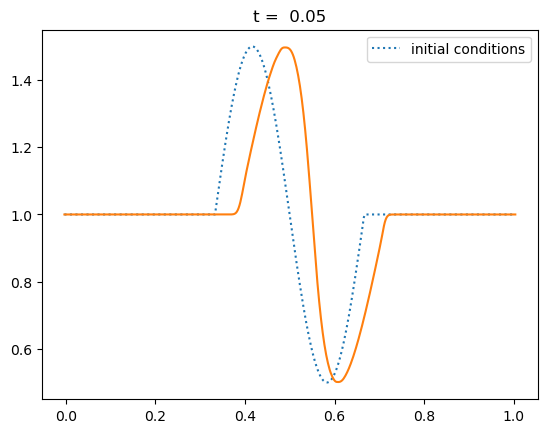

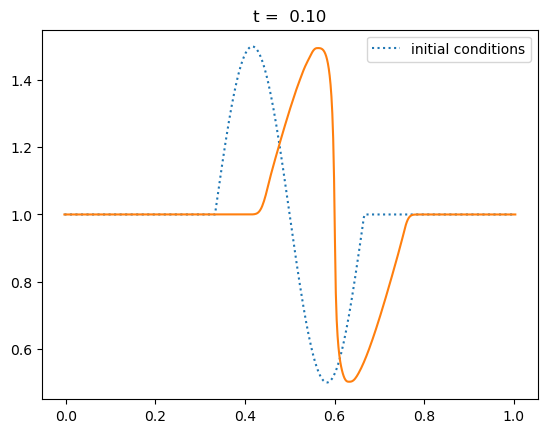

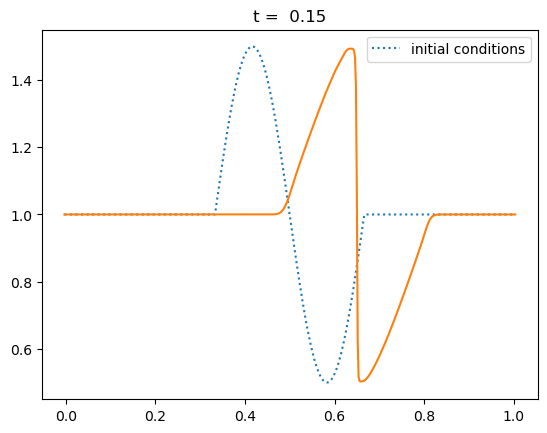

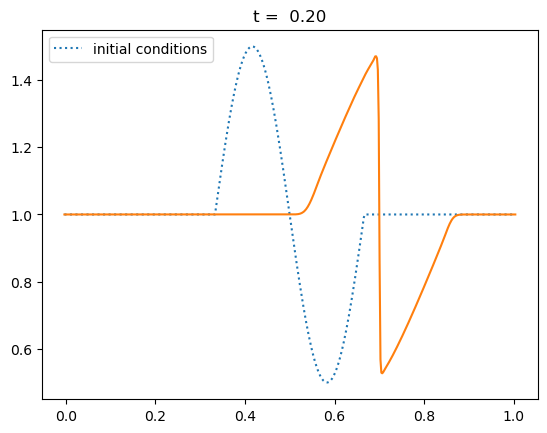

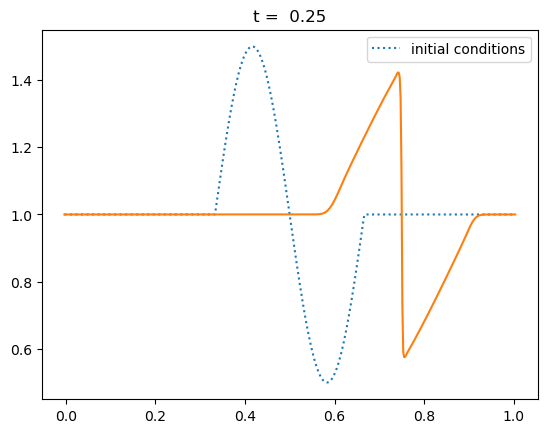

In [25]:
nx = 512
C = 0.5
tmax = 0.25

for tmax in [0.05, 0.10, 0.15, 0.20, 0.25]:
    g = burgers_mol(nx, C, tmax, init_cond=sine)
    fig = g.plot(title=f"t = {tmax:5.2f}")

Keep in mind that although our method ideally converges as second order in space and time, the slope limiter we use kicks in near discontinuities and reduces the converges locally to first order there.

## Rarefaction

Now let's setup initial conditions that give rise to a rarefaction.

In [26]:
def rare(g):
    g.u[:] = 1.0
    g.u[g.x > 0.5] = 2.0

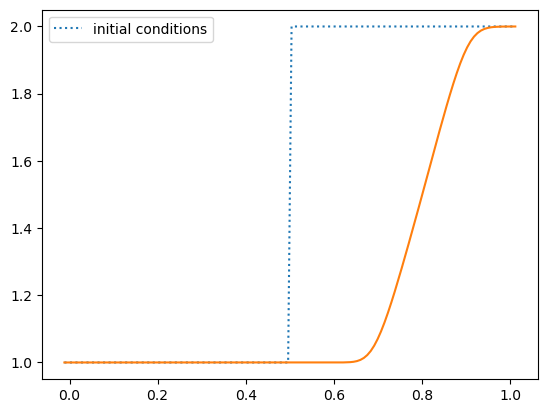

In [27]:
nx = 128
C = 0.5
tmax = 0.2

g = burgers_mol(nx, C, tmax, init_cond=rare)
fig = g.plot()

## Shock

Now we can do some initial conditions that are a shock from $t= 0$.  This can be used to test if we get the correct shock speed with our method.

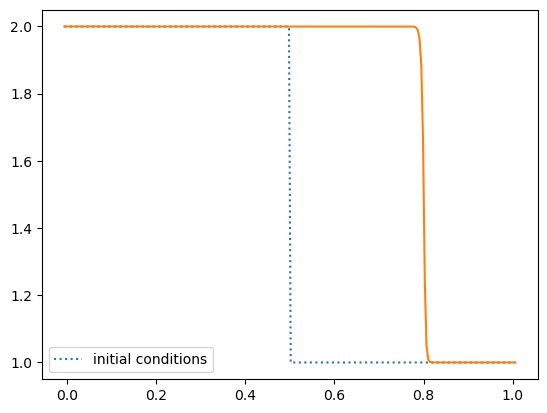

In [28]:
def shock(g):
    g.u[:] = 2.0
    g.u[g.x > 0.5] = 1.0

nx = 256
g = burgers_mol(nx, C, tmax, init_cond=shock)
fig = g.plot()

We see that at the end, the shock is at a position of 0.8 and that it started at 0.5.  We can just compute the shock speed as $(x_\mathrm{final} - x_\mathrm{initial}) / \Delta t$.  Let's find
these positions more accurately.

In [29]:
x0 = g.x[g.uinit <= 1.5][0]
x1 = g.x[g.u <= 1.5][0]

In [30]:
S = (x1 - x0) / tmax
S

1.50390625

This is the expected result from the jump conditions.  Because we solve the Riemann problem, which knows about the jump conditions, we get the shock speed correct.  These methods are therefore sometimes called [*shock-capturing methods*](https://en.wikipedia.org/wiki/Shock-capturing_method).